The purpose of this code is to quantify the nuclei, the size and number of synuclein inclusions for each image.

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

Define Sub Functions

In [2]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 10000

In [ ]:
def show_image(image):
    """Display a grayscale image using matplotlib."""
    io.imshow(image, cmap='gray')
    plt.show()

def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))


def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    return confocal_img


def preprocess_dapi_channel(dapi_channel):
    """
    Preprocess the DAPI (nuclear stain) channel for nucleus detection.
    - Applies Gaussian blur to smooth noise.
    - Uses Otsu thresholding to binarize the image.
    - Removes small objects likely to be noise.
    - Expands regions slightly using dilation to connect fragmented nuclei.
    - Labels connected regions.
    """
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image


def count_nuclei(labeled_image):
    """
    Count the number of labeled nuclei.
    Subtract 1 since label '0' is background.
    """
    return len(np.unique(labeled_image)) - 1


def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)
    show_image(green_channel_remove_inclusions)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None


def extract_inclusions(green_channel, mask, display_graph=False):
    """
    Extract potential inclusions inside a cell.
    - Blurs and masks the cell region.
    - Computes intensity statistics for thresholding.
    - Applies different threshold strategies depending on intensity distribution.
    - Removes objects that are too small or too large to be inclusions.
    - Optionally shows histogram for debugging.
    """
    applied_mask_blurred = gaussian(green_channel, sigma=1) * mask
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0]


    # Normalize the signal within the masked region
    applied_mask_eliminate_background = normalize_image(applied_mask_eliminate_background)


    # Compute descriptive statistics for intensity distribution
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
    applied_mask = green_channel * mask


    # Decide on thresholding strategy based on upper quartile
    if q3 < 0.4 and len(bin_edges) > 20:
        threshold = max(threshold_otsu(applied_mask), 0.5)
    elif q3 >= 0.9:
        threshold = 1  # very high, to exclude everything
    else:
        threshold = 0.999  # conservatively high


    # Apply threshold and size-based filters
    inclusions = applied_mask > threshold
    inclusions = remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE)
    inclusions = inclusions ^ remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE)


    # Optional histogram display
    if display_graph:
        print("Threshold: ", threshold)
        print("Bin count", len(bin_edges))
        plt.hist(applied_mask_eliminate_background, bins='fd')
        plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
        plt.legend()
        plt.title("Intensity histogram")
        plt.show()


    return inclusions


def generate_inclusion_image(green_channel, labeled_cells):
    """
    Generate a binary image with all inclusions from all cells.
    - Loops through each segmented cell.
    - Extracts inclusions from each cell region.
    - Combines all into one final binary image.
    """
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        mask = labeled_cells == cell.label
        inclusions = extract_inclusions(green_channel, mask)
        inclusion_image += inclusions  # adds binary inclusion mask

    return inclusion_image




In [ ]:
def analyze_image(image_path, basename):
    """
    Analyze an image to extract inclusion metrics on a per-cell and per-image basis.
    
    Args:
        image_path (str): Path to the .czi microscopy image file.
        basename (str): A base name used for tagging output records with their source file.

    Returns:
        tuple:
            - df1 (pd.DataFrame): Image-level summary including total nuclei and inclusions.
            - df2 (pd.DataFrame): Cell-level summary including inclusion counts per cell.
            - df3 (pd.DataFrame): Inclusion-level data including area and associated cell.
    """
    
    # Load the multi-channel image and remove unnecessary dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)

    # Extract green (e.g., inclusion marker) and DAPI (nuclei marker) channels
    green_channel = image_squeezed[0, :, :]
    dapi_channel = image_squeezed[1, :, :]

    # Preprocess green channel for cell segmentation
    green_channel = preprocess_green_channel(green_channel)
    print("Green Channel")
    show_image(green_channel)

    # Preprocess DAPI channel and count nuclei
    labeled_image_dapi = preprocess_dapi_channel(dapi_channel)
    num_nuclei = count_nuclei(labeled_image_dapi)

    # Segment individual cells from the green channel
    labeled_cells = segment_cells(green_channel)
    print("Segmented Cells")
    show_image(labeled_cells)

    # Initialize lists to accumulate per-cell and per-inclusion results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []
    inclusion_counter_cells = []

    # Loop over each detected cell for inclusion analysis
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:  # Skip tiny regions likely to be noise
            continue

        cell_counter.append(i)
        cell_size.append(cell.area)

        # Create a mask for the current cell
        mask = labeled_cells == cell.label

        # Detect inclusions within the cell mask in the green channel
        inclusions = extract_inclusions(green_channel, mask, display_graph=True)
        inclusions_labeled = label(inclusions)

        # Calculate area for each detected inclusion
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled)]
        
        if len(inclusion_areas) > 0:
            show_image(inclusions)
            print(f"Cell {i}: Number of inclusions: {len(inclusion_areas)}")
            print(f"Cell {i}: Inclusion areas: {inclusion_areas}")
        
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)

        # Append inclusion metrics to relevant lists
        total_inclusion_areas.append(total_inclusion_area)
        num_inclusions.append(len(inclusion_areas))
        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))
        inclusion_counter_cells.append([i] * len(inclusion_areas))
        average_inclusion_areas.append(average_inclusion_area)

    # Create a DataFrame summarizing the whole image
    df1 = pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Number_of_Nuclei": [num_nuclei],
        "Number_of_Inclusions_per_Nucleus": [np.sum(num_inclusions) / num_nuclei],
    })

    # Create a DataFrame summarizing each cell
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Num_Inclusions": num_inclusions
    })

    # Create a DataFrame for each inclusion with its area and associated cell
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Cell": np.concatenate(inclusion_counter_cells),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    return df1, df2, df3


In [ ]:
def analyze_all_images(image_folder):
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for image in os.listdir(image_folder):
        
        if image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(image)

            well_image_path = os.path.join(image_folder, image)
            well_image_base_name = os.path.basename(image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image_NEW.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:6]}_analysis_by_cell_NEW.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:6]}_analysis_by_inclusion_NEW.xlsx", index=False)

Define Main Function

In [6]:
folders = ['011124_PFF_SCR_TAX_ADAM/new settings', '251024_PFF_SCR_TAX_ADAM', '281024_PFF_SCR_TAX_ADAM_800/new new settings','291024_PFF_SCR_TAX_ADAM_780', '120524_PFF_SCR_TAX_ADAM_800']

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


1K_ADAMTS19_01.czi
Green Channel


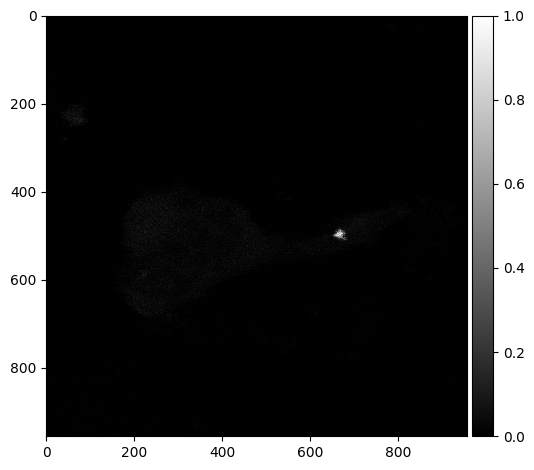

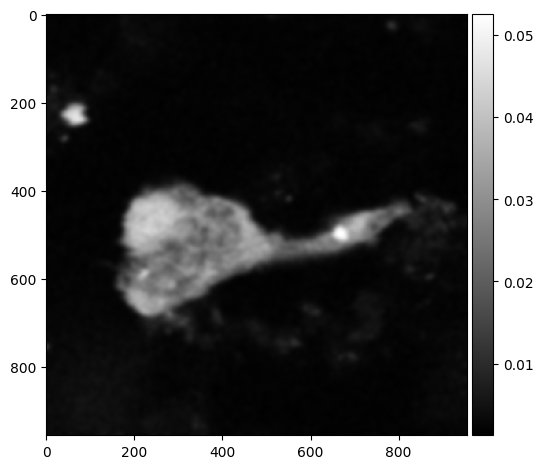

Segmented Cells


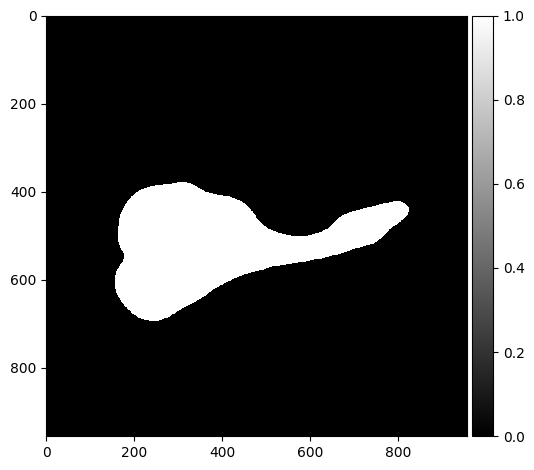

Threshold:  0.5
Bin count 1399


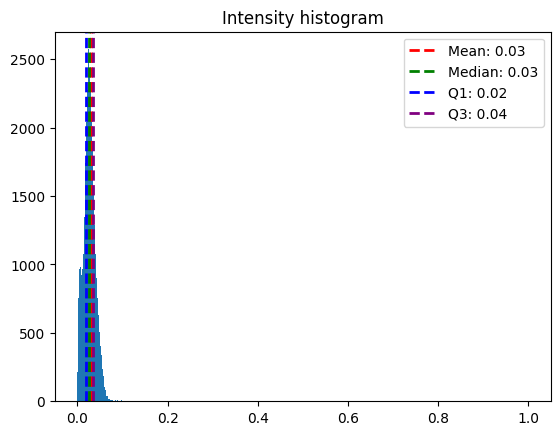

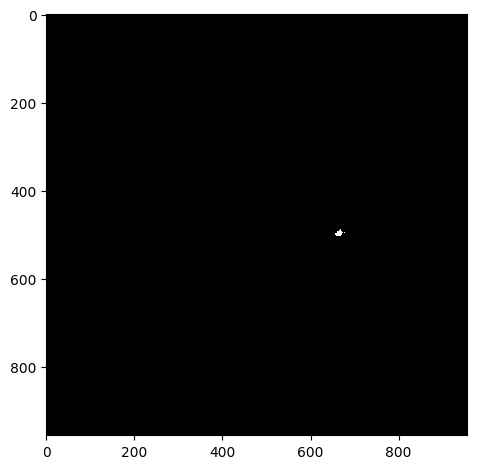

Cell 0: Number of inclusions: 1
Cell 0: Inclusion areas: [np.float64(194.0)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_02.czi
Green Channel


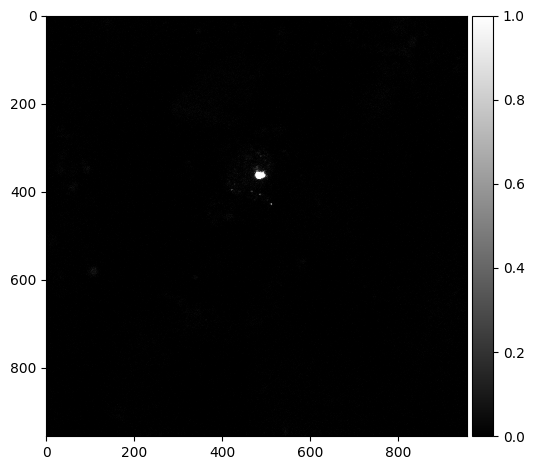

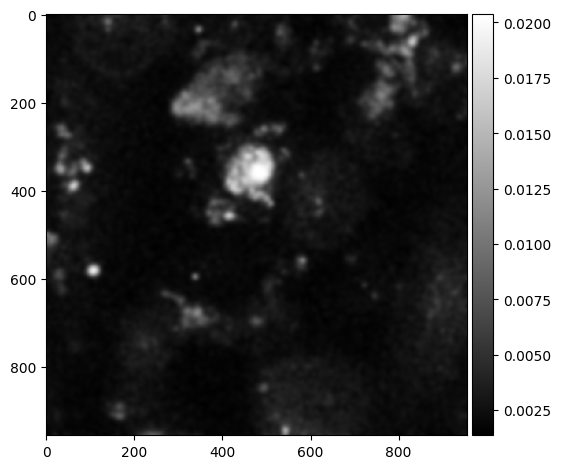

Segmented Cells


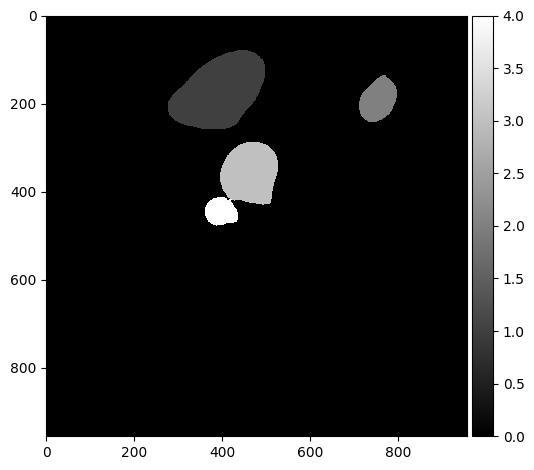

Threshold:  0.5
Bin count 91


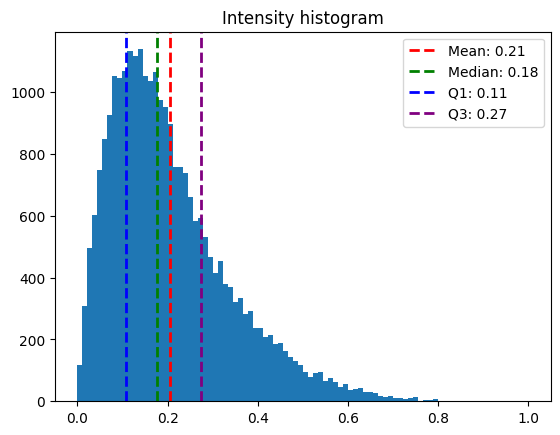

Threshold:  0.5
Bin count 45


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


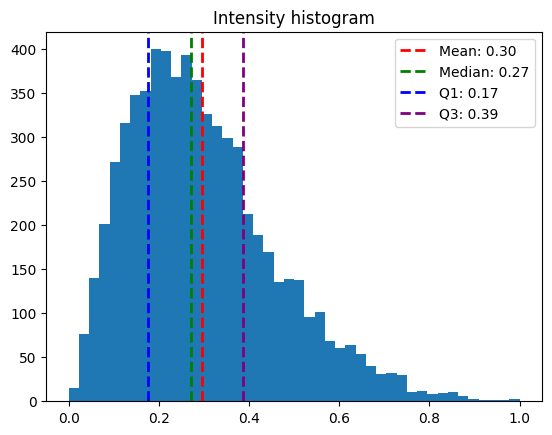

Threshold:  0.5
Bin count 838


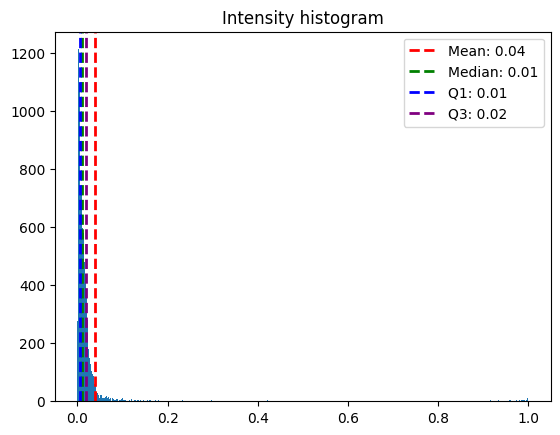

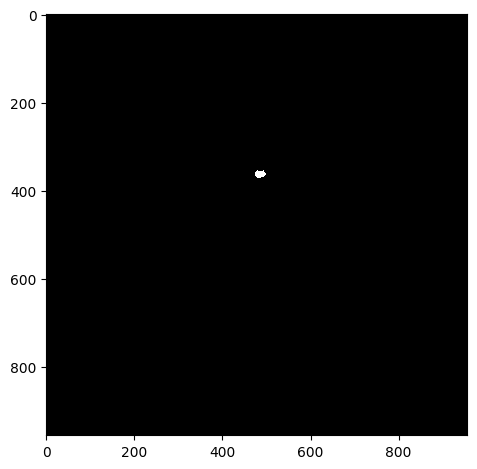

Cell 2: Number of inclusions: 1
Cell 2: Inclusion areas: [np.float64(334.0)]
Threshold:  0.5
Bin count 75


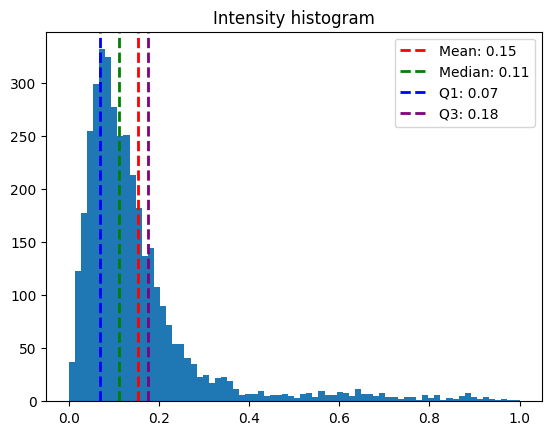

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_03.czi
Green Channel


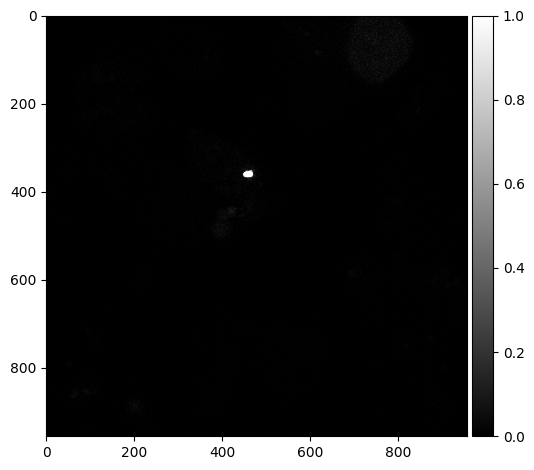

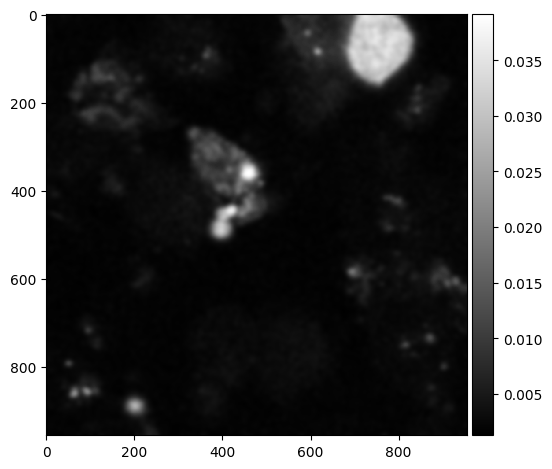

Segmented Cells


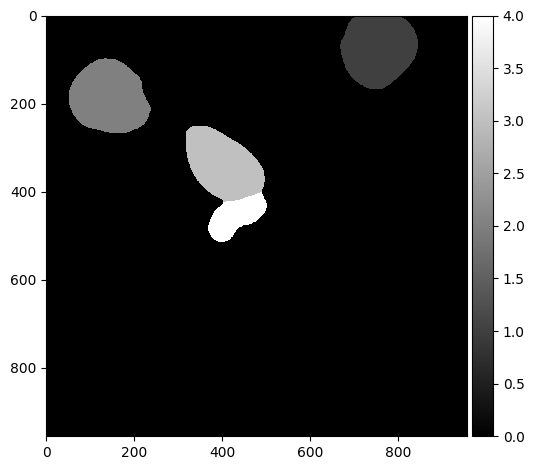

Threshold:  0.999
Bin count 58


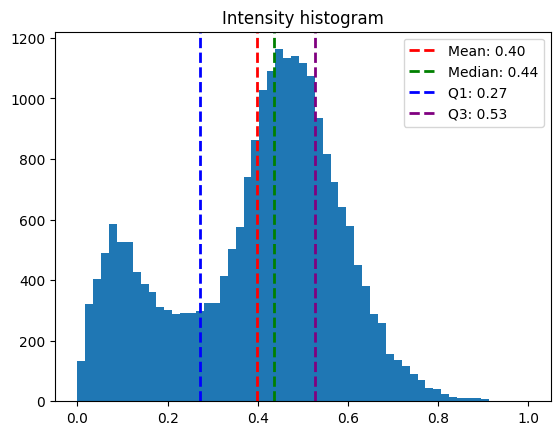

Threshold:  0.5
Bin count 85


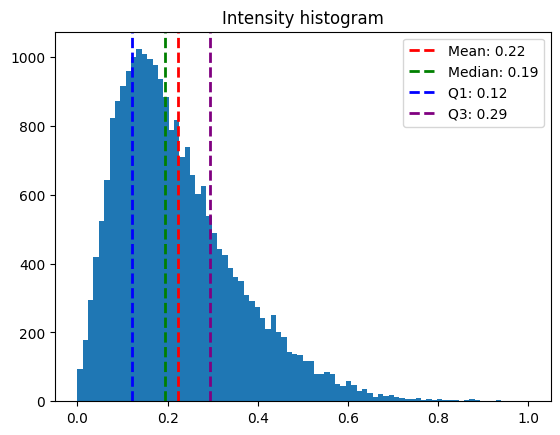

Threshold:  0.5
Bin count 1935


KeyboardInterrupt: 

In [7]:

analyze_all_images(folders[0])
# for folder in folders:
#     analyze_all_images(folder)


In [ ]:
analyze_all_images(folders[1])

In [ ]:
analyze_all_images(folders[2])

In [ ]:
analyze_all_images(folders[3])

In [ ]:
analyze_all_images(folders[4])